---
# コーディングプロダクト
---
### 【概要】
### 　　EMNIST判別の正解率を最適化する(目標95%程度)

### 【データセット】
### 　　EMNIST (アルファベット26文字)

### 【比較モデル】
### 　　全結合層ネットワーク
### 　　CNNネットワーク
### 　　(※ バッチ正規化、ドロップアウト、初期重み等をパラメータ振って比較)

---
### ライブラリのインポート
---

In [115]:
# 標準システム系ライブラリ
import sys
import random
import os

# 機械学習の基本ライブラリ
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split  # テストデータの分割
import matplotlib.pyplot as plt

# torchvision
import torchvision.datasets                        # データセット
import torchvision.models                          # AlexNetなど
import torchvision.transforms as transforms        # 画像Augumentation,resize、正規化

# PyTorch
import torch                                       # Tensorの作成や操作
import torch.nn as nn                              # ニューラルネットワーク
import torch.nn.functional as F                    # 関数をメソッドとして提供
import torch.optim as optim                        # オプティマイザ
from torch.utils.data import Dataset, DataLoader   # データセット、データローダー
from torch.autograd import Variable                # 勾配計算

# GPUの使用状況確認
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


---
### データセット読み込み
---

In [116]:
# EMNISTのcsv読み込み
train_df = pd.read_csv("/kaggle/input/emnist/emnist-letters-train.csv",dtype=np.float32)
test_df = pd.read_csv("/kaggle/input/emnist/emnist-letters-test.csv",dtype=np.float32)

# 入力データとラベルを分割
train_x = train_df.loc[:,train_df.columns!='23'].values
train_x_norm = train_x/255
train_y = train_df['23'].values
train_y = train_y - 1 # ラベル範囲が(1-26)のためゼロ始まりにする

# 訓練/評価用データに分割(0.8:0.2)
x_train, x_val, y_train, y_val = \
                train_test_split(train_x_norm, train_y, test_size=0.2)

# テンソルに変換
x_train_tensor = torch.from_numpy(x_train)
y_train_tensor = torch.from_numpy(y_train).type(torch.LongTensor)

x_val_tensor = torch.from_numpy(x_val)
y_val_tensor = torch.from_numpy(y_val).type(torch.LongTensor)

---
### データセットの内容を確認
---

<Figure size 640x480 with 0 Axes>

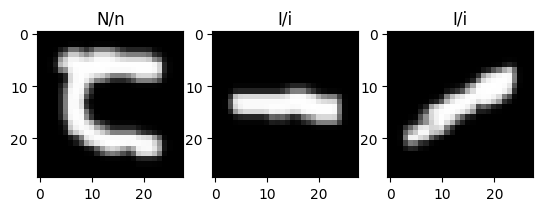

In [117]:
# データのラベルを確認する
label = ["A/a","B/b","C/c","D/d","E/e","F/f",
         "G/g","H/h","I/i","J/j","K/k","L/l",
         "M/m","N/n","O/o","P/p","Q/q","R/r",
         "S/s","T/t","U/u","V/v","W/w","X/x",
         "Y/y","Z/z"]

num = random.randint(0,len(train_df)-3)

# サンプル画像を表示する
plt.gray()
j = 0
fig = plt.figure()
for i in range(num, num+3, 1):
    fig.add_subplot(1,3,j+1).set_title(str(label[train_y[i].astype(int)]))
    plt.imshow(train_x[i].reshape(28,28))
    j = j + 1    
plt.show()

---
### データローダーの作成
---

In [118]:
# バッチサイズ
batch_size = 256

# データセット
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(x_val_tensor, y_val_tensor)

# データローダー
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

---
### 【モデル作成 (ベースライン)】
### 　　全結合層を用いた3層構成
### 　　(入力層:784 → 隠れ層:256 → 出力層26)
---

In [119]:
class Net(nn.Module):
    
    # ネットワーク構造の定義
    def __init__(self, in_size, h_size, out_size):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(in_size,h_size)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(h_size,out_size)
        self.softmax = torch.nn.Softmax(dim=1)
        
    # 順伝播
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out
    
# インスタンス化(入力:784, 隠れ層:256, 出力:26)
net = Net(784,256,26).to(device)

# 最適化手法の選択(Adam, 学習率=0.001)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# 目的関数 (cross_entropyは内部でsoftmaxが使用されている)
criterion = nn.CrossEntropyLoss()

In [120]:
# エポックの数
max_epoch = 30

# モデルの初期化
torch.manual_seed(0)

# 訓練データ結果
y_train_acc = []
y_train_loss = []

# 検証データ結果
y_val_acc = []
y_val_loss = []

# 学習ループ
for epoch in range(max_epoch):
    
    # 訓練モード
    net.train()
    
    for x, t in train_loader:
        
        # パラメータの勾配を初期化
        optimizer.zero_grad()
        
        # 入力データとラベルをGPU用に変換
        x = x.to(device)
        t = t.to(device)
        
        # 予測値の算出
        y = net(x)
        
        # ラベルと予測値とのロス計算
        loss = criterion(y,t)
                
        # 各パラメータの勾配を算出
        loss.backward()
        
        # パラメータ更新
        optimizer.step()

    net.eval() # 評価モード
        
    # ---epochごとの結果を出力--------------------
    # 訓練データの計算
    tmp_xtrain = x_train_tensor.to(device)
    tmp_ytrain = y_train_tensor.to(device)
    # valデータの計算
    tmp_xval = x_val_tensor.to(device)
    tmp_yval = y_val_tensor.to(device)

    # 予測
    y1 = net(tmp_xtrain)
    loss1 = criterion(y1,tmp_ytrain)
    
    y2 = net(tmp_xval)
    loss2 = criterion(y2,tmp_yval)

    # 最大値を抽出
    y_pred1 = torch.argmax(y1,1)
    y_pred2 = torch.argmax(y2,1)

    # numpyに変換
    y_pred1 = y_pred1.to('cpu').detach().numpy().copy()
    y_pred2 = y_pred2.to('cpu').detach().numpy().copy()
    
    # 正解率表示
    from sklearn.metrics import accuracy_score, log_loss # 正解率の評価
    acc1 = accuracy_score(y_pred1,y_train)
    acc2 = accuracy_score(y_pred2,y_val)

    y_train_acc.append(acc1)    
    y_val_acc.append(acc2)    
    
    # ロス値
    y_train_loss.append(loss1.to('cpu').detach())
    y_val_loss.append(loss2.to('cpu').detach())
    
    # 目的関数の値を表示して確認
    print('epoch: {}'.format(epoch+1))
    print('[train] Loss: {:.4g}  Accuracy: {:.4g} %'.format(y_train_loss[epoch], y_train_acc[epoch]*100))
    print('[valid] Loss: {:.4g}  Accuracy: {:.4g} %'.format(y_val_loss[epoch], y_val_acc[epoch]*100))    

epoch: 1
[train] Loss: 2.722  Accuracy: 61.89 %
[valid] Loss: 2.726  Accuracy: 61.36 %
epoch: 2
[train] Loss: 2.679  Accuracy: 65.65 %
[valid] Loss: 2.686  Accuracy: 64.9 %
epoch: 3
[train] Loss: 2.63  Accuracy: 70.56 %
[valid] Loss: 2.639  Accuracy: 69.62 %
epoch: 4
[train] Loss: 2.601  Accuracy: 73.47 %
[valid] Loss: 2.611  Accuracy: 72.3 %
epoch: 5
[train] Loss: 2.583  Accuracy: 75.05 %
[valid] Loss: 2.595  Accuracy: 73.6 %
epoch: 6
[train] Loss: 2.572  Accuracy: 76.14 %
[valid] Loss: 2.585  Accuracy: 74.47 %
epoch: 7
[train] Loss: 2.537  Accuracy: 79.7 %
[valid] Loss: 2.553  Accuracy: 77.96 %
epoch: 8
[train] Loss: 2.526  Accuracy: 80.63 %
[valid] Loss: 2.544  Accuracy: 78.75 %
epoch: 9
[train] Loss: 2.52  Accuracy: 81.21 %
[valid] Loss: 2.539  Accuracy: 79.18 %
epoch: 10
[train] Loss: 2.515  Accuracy: 81.63 %
[valid] Loss: 2.535  Accuracy: 79.58 %
epoch: 11
[train] Loss: 2.51  Accuracy: 82.06 %
[valid] Loss: 2.532  Accuracy: 79.77 %
epoch: 12
[train] Loss: 2.506  Accuracy: 82.41 %

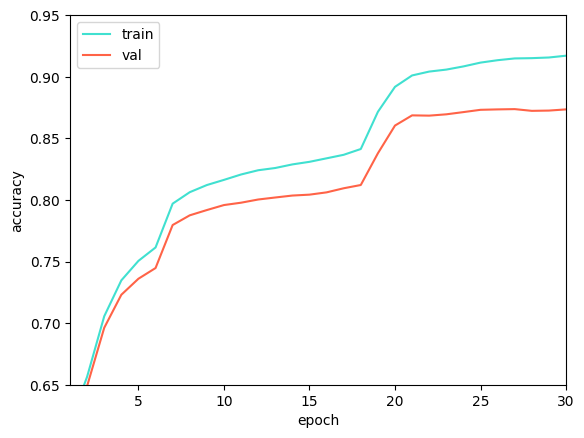

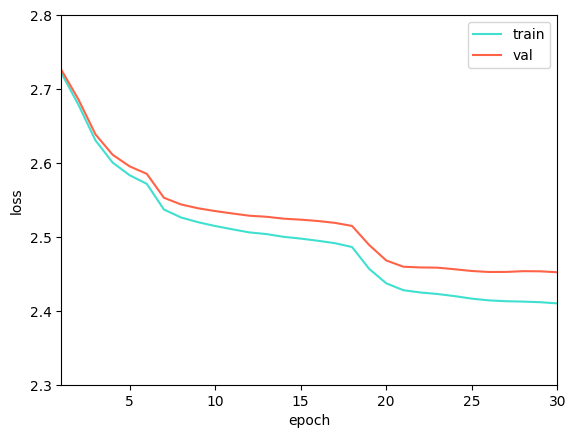

In [121]:
# 正解率を表示
x = range(1,31,1)
plt.xlim(1,30)
plt.ylim(0.65,0.95)
plt.plot(x, y_train_acc,label="train",color="turquoise")
plt.plot(x, y_val_acc,label="val",color="tomato")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# lossを表示
x = range(1,31,1)
plt.xlim(1,30)
plt.ylim(2.3,2.8)
plt.plot(x, y_train_loss,label="train",color="turquoise")
plt.plot(x, y_val_loss,label="val",color="tomato")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

### 【現状確認】
#### 正解率
- 10 epoch: 79.58%
- 20 epoch: 86.04%
- 30 epoch: 87.35%

### 【考察】
- 10epochあたりから学習が停滞してしまい、正解率が横ばいになっている
- 訓練データ/検証データ間で正解率に差が見られる。各層の重みが小or大に偏って学習が進んでいない可能性あり

### 【方策】
1. 重みの初期値を「Heの初期値」にする
2. 「バッチ正規化」 or 「ドロップアウト」などを加え、重みの偏りを改善させる
3. 層をより深くして表現力を高める

---
### 【モデル作成】
### 　　1. 重みの初期値を「Heの初期値」にする
### 　　(入力層:784 → 隠れ層:256 → 出力層26)
---

In [122]:
class Net(nn.Module):
    
    # ネットワーク構造の定義
    def __init__(self, in_size, h_size, out_size):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(in_size,h_size)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(h_size,out_size)
        self.softmax = torch.nn.Softmax(dim=1)

        torch.nn.init.kaiming_normal_(self.fc1.weight, a=0, mode='fan_in', nonlinearity='relu')
        
    # 順伝播
    def forward(self, x):
        out = self.fc1(x)
#         out = self.bn1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out
    
# インスタンス化(入力:784, 隠れ層:256, 出力:26)
net = Net(784,256,26).to(device)

# 最適化手法の選択(Adam, 学習率=0.001)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# 目的関数 (cross_entropyは内部でsoftmaxが使用されている)
criterion = nn.CrossEntropyLoss()

In [123]:
# エポックの数
max_epoch = 30

# モデルの初期化
torch.manual_seed(0)

# 訓練データ結果
y_train_acc = []
y_train_loss = []

# 検証データ結果
y_val_acc = []
y_val_loss = []

# 学習ループ
for epoch in range(max_epoch):
    
    # 訓練モード
    net.train()
    
    for x, t in train_loader:
        
        # パラメータの勾配を初期化
        optimizer.zero_grad()
        
        # 入力データとラベルをGPU用に変換
        x = x.to(device)
        t = t.to(device)
        
        # 予測値の算出
        y = net(x)
        
        # ラベルと予測値とのロス計算
        loss = criterion(y,t)
                
        # 各パラメータの勾配を算出
        loss.backward()
        
        # パラメータ更新
        optimizer.step()

    net.eval() # 評価モード
        
    # ---epochごとの結果を出力--------------------
    # 訓練データの計算
    tmp_xtrain = x_train_tensor.to(device)
    tmp_ytrain = y_train_tensor.to(device)
    # valデータの計算
    tmp_xval = x_val_tensor.to(device)
    tmp_yval = y_val_tensor.to(device)

    # 予測
    y1 = net(tmp_xtrain)
    loss1 = criterion(y1,tmp_ytrain)
    
    y2 = net(tmp_xval)
    loss2 = criterion(y2,tmp_yval)

    # 最大値を抽出
    y_pred1 = torch.argmax(y1,1)
    y_pred2 = torch.argmax(y2,1)

    # numpyに変換
    y_pred1 = y_pred1.to('cpu').detach().numpy().copy()
    y_pred2 = y_pred2.to('cpu').detach().numpy().copy()
    
    # 正解率表示
    from sklearn.metrics import accuracy_score, log_loss # 正解率の評価
    acc1 = accuracy_score(y_pred1,y_train)
    acc2 = accuracy_score(y_pred2,y_val)

    y_train_acc.append(acc1)    
    y_val_acc.append(acc2)    
    
    # ロス値
    y_train_loss.append(loss1.to('cpu').detach())
    y_val_loss.append(loss2.to('cpu').detach())
    
    # 目的関数の値を表示して確認
    print('epoch: {}'.format(epoch+1))
    print('[train] Loss: {:.4g}  Accuracy: {:.4g} %'.format(y_train_loss[epoch], y_train_acc[epoch]*100))
    print('[valid] Loss: {:.4g}  Accuracy: {:.4g} %'.format(y_val_loss[epoch], y_val_acc[epoch]*100))    

epoch: 1
[train] Loss: 2.697  Accuracy: 64.45 %
[valid] Loss: 2.702  Accuracy: 63.98 %
epoch: 2
[train] Loss: 2.651  Accuracy: 68.69 %
[valid] Loss: 2.659  Accuracy: 67.85 %
epoch: 3
[train] Loss: 2.622  Accuracy: 71.34 %
[valid] Loss: 2.634  Accuracy: 70.18 %
epoch: 4
[train] Loss: 2.576  Accuracy: 76.04 %
[valid] Loss: 2.588  Accuracy: 74.58 %
epoch: 5
[train] Loss: 2.553  Accuracy: 78.3 %
[valid] Loss: 2.568  Accuracy: 76.55 %
epoch: 6
[train] Loss: 2.54  Accuracy: 79.5 %
[valid] Loss: 2.556  Accuracy: 77.68 %
epoch: 7
[train] Loss: 2.53  Accuracy: 80.34 %
[valid] Loss: 2.548  Accuracy: 78.45 %
epoch: 8
[train] Loss: 2.522  Accuracy: 81.02 %
[valid] Loss: 2.541  Accuracy: 78.95 %
epoch: 9
[train] Loss: 2.516  Accuracy: 81.57 %
[valid] Loss: 2.537  Accuracy: 79.4 %
epoch: 10
[train] Loss: 2.51  Accuracy: 82.05 %
[valid] Loss: 2.533  Accuracy: 79.66 %
epoch: 11
[train] Loss: 2.505  Accuracy: 82.45 %
[valid] Loss: 2.529  Accuracy: 79.8 %
epoch: 12
[train] Loss: 2.502  Accuracy: 82.73 %

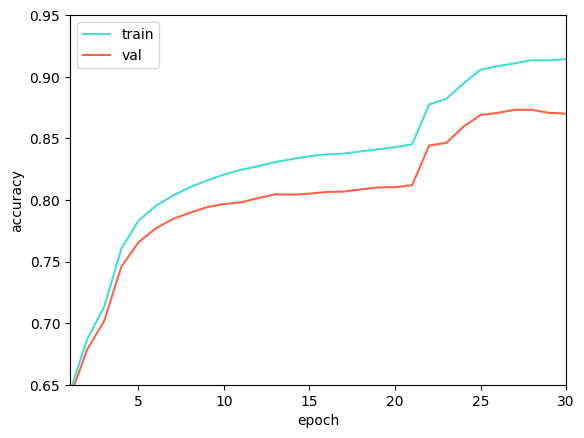

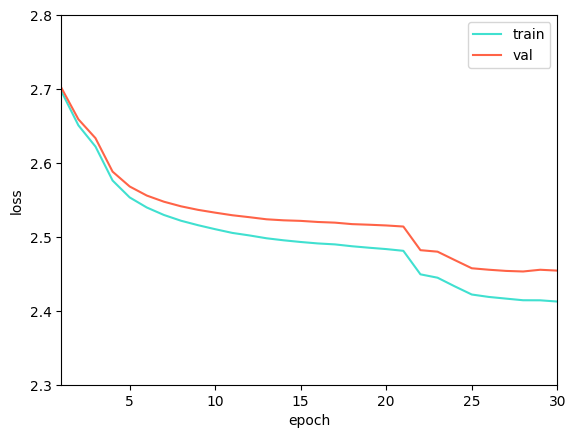

In [124]:
# 正解率を表示
x = range(1,31,1)
plt.xlim(1,30)
plt.ylim(0.65,0.95)
plt.plot(x, y_train_acc,label="train",color="turquoise")
plt.plot(x, y_val_acc,label="val",color="tomato")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# lossを表示
x = range(1,31,1)
plt.xlim(1,30)
plt.ylim(2.3,2.8)
plt.plot(x, y_train_loss,label="train",color="turquoise")
plt.plot(x, y_val_loss,label="val",color="tomato")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

#### 【正解率】 (ベース) → (Heの初期値)
- 10 epoch: 79.58% → 79.66% 
- 20 epoch: 86.04% → 81.04%
- 30 epoch: 87.35% → 87%

---
### 【モデル作成】
### 　　2. 「バッチ正規化」を加え、重みの偏りを改善させる
### 　　(入力層:784 → 隠れ層:256 → 出力層26)
---

In [125]:
class Net(nn.Module):
    
    # ネットワーク構造の定義
    def __init__(self, in_size, h_size, out_size):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(in_size,h_size)
        self.bn1 = nn.BatchNorm1d(h_size, track_running_stats=True)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(h_size,out_size)
        self.softmax = torch.nn.Softmax(dim=1)

        torch.nn.init.kaiming_normal_(self.fc1.weight, a=0, mode='fan_in', nonlinearity='relu')
        
    # 順伝播
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out
    
# インスタンス化(入力:784, 隠れ層:256, 出力:26)
net = Net(784,256,26).to(device)

# 最適化手法の選択(Adam, 学習率=0.001)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# 目的関数 (cross_entropyは内部でsoftmaxが使用されている)
criterion = nn.CrossEntropyLoss()

In [126]:
# エポックの数
max_epoch = 30

# モデルの初期化
torch.manual_seed(0)

# 訓練データ結果
y_train_acc = []
y_train_loss = []

# 検証データ結果
y_val_acc = []
y_val_loss = []

# 学習ループ
for epoch in range(max_epoch):
    
    # 訓練モード
    net.train()
    
    for x, t in train_loader:
        
        # パラメータの勾配を初期化
        optimizer.zero_grad()
        
        # 入力データとラベルをGPU用に変換
        x = x.to(device)
        t = t.to(device)
        
        # 予測値の算出
        y = net(x)
        
        # ラベルと予測値とのロス計算
        loss = criterion(y,t)
                
        # 各パラメータの勾配を算出
        loss.backward()
        
        # パラメータ更新
        optimizer.step()

    net.eval() # 評価モード
        
    # ---epochごとの結果を出力--------------------
    # 訓練データの計算
    tmp_xtrain = x_train_tensor.to(device)
    tmp_ytrain = y_train_tensor.to(device)
    # valデータの計算
    tmp_xval = x_val_tensor.to(device)
    tmp_yval = y_val_tensor.to(device)

    # 予測
    y1 = net(tmp_xtrain)
    loss1 = criterion(y1,tmp_ytrain)
    
    y2 = net(tmp_xval)
    loss2 = criterion(y2,tmp_yval)

    # 最大値を抽出
    y_pred1 = torch.argmax(y1,1)
    y_pred2 = torch.argmax(y2,1)

    # numpyに変換
    y_pred1 = y_pred1.to('cpu').detach().numpy().copy()
    y_pred2 = y_pred2.to('cpu').detach().numpy().copy()
    
    # 正解率表示
    from sklearn.metrics import accuracy_score, log_loss # 正解率の評価
    acc1 = accuracy_score(y_pred1,y_train)
    acc2 = accuracy_score(y_pred2,y_val)

    y_train_acc.append(acc1)    
    y_val_acc.append(acc2)    
    
    # ロス値
    y_train_loss.append(loss1.to('cpu').detach())
    y_val_loss.append(loss2.to('cpu').detach())
    
    # 目的関数の値を表示して確認
    print('epoch: {}'.format(epoch+1))
    print('[train] Loss: {:.4g}  Accuracy: {:.4g} %'.format(y_train_loss[epoch], y_train_acc[epoch]*100))
    print('[valid] Loss: {:.4g}  Accuracy: {:.4g} %'.format(y_val_loss[epoch], y_val_acc[epoch]*100))    

epoch: 1
[train] Loss: 2.604  Accuracy: 75.68 %
[valid] Loss: 2.614  Accuracy: 74.85 %
epoch: 2
[train] Loss: 2.544  Accuracy: 80.63 %
[valid] Loss: 2.56  Accuracy: 79.09 %
epoch: 3
[train] Loss: 2.5  Accuracy: 84.85 %
[valid] Loss: 2.52  Accuracy: 82.65 %
epoch: 4
[train] Loss: 2.479  Accuracy: 86.46 %
[valid] Loss: 2.502  Accuracy: 84.19 %
epoch: 5
[train] Loss: 2.465  Accuracy: 87.59 %
[valid] Loss: 2.491  Accuracy: 85 %
epoch: 6
[train] Loss: 2.455  Accuracy: 88.38 %
[valid] Loss: 2.484  Accuracy: 85.55 %
epoch: 7
[train] Loss: 2.448  Accuracy: 88.99 %
[valid] Loss: 2.478  Accuracy: 85.96 %
epoch: 8
[train] Loss: 2.441  Accuracy: 89.5 %
[valid] Loss: 2.474  Accuracy: 86.18 %
epoch: 9
[train] Loss: 2.436  Accuracy: 90 %
[valid] Loss: 2.47  Accuracy: 86.45 %
epoch: 10
[train] Loss: 2.429  Accuracy: 90.57 %
[valid] Loss: 2.465  Accuracy: 86.95 %
epoch: 11
[train] Loss: 2.424  Accuracy: 91.02 %
[valid] Loss: 2.463  Accuracy: 87.19 %
epoch: 12
[train] Loss: 2.419  Accuracy: 91.38 %
[val

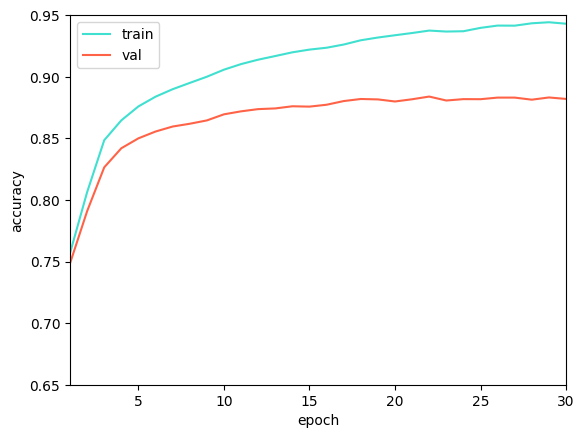

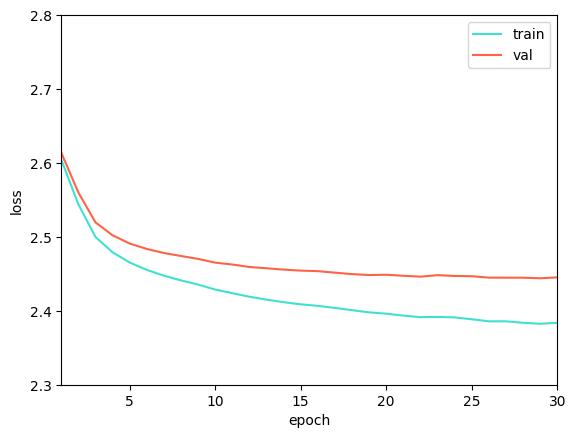

In [127]:
# 正解率を表示
x = range(1,31,1)
plt.xlim(1,30)
plt.ylim(0.65,0.95)
plt.plot(x, y_train_acc,label="train",color="turquoise")
plt.plot(x, y_val_acc,label="val",color="tomato")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# lossを表示
x = range(1,31,1)
plt.xlim(1,30)
plt.ylim(2.3,2.8)
plt.plot(x, y_train_loss,label="train",color="turquoise")
plt.plot(x, y_val_loss,label="val",color="tomato")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

#### 【正解率】 (ベース) → (Heの初期値) → (バッチ正規化)
- 10 epoch: 79.58% → 79.66% → 86.95%
- 20 epoch: 86.04% → 81.04% → 87.99%
- 30 epoch: 87.35% → 87% → 88.2%

---
### 【モデル作成】
### 　　3. 層をより深くして表現力を高める
### 　　(入力層:784 → 隠れ層:256→100→100→100 → 出力層26)
---

In [128]:
# モデル構築(全結合層x6)
class Net(nn.Module):
    
    # ネットワーク構造の定義
    def __init__(self, in_size, h1_size, h2_size, h3_size, h4_size, out_size):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(in_size,h1_size)
        self.bn1 = nn.BatchNorm1d(h1_size, track_running_stats=True)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(h1_size,h2_size)
        self.bn2 = nn.BatchNorm1d(h2_size, track_running_stats=True)
        self.relu2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(h2_size,h3_size)
        self.bn3 = nn.BatchNorm1d(h3_size, track_running_stats=True)
        self.relu3 = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(h3_size,h4_size)
        self.bn4 = nn.BatchNorm1d(h4_size, track_running_stats=True)
        self.relu4 = torch.nn.ReLU()
        self.bn5 = nn.BatchNorm1d(h4_size, track_running_stats=True)
        self.fc5 = torch.nn.Linear(h4_size,out_size)
        self.softmax = torch.nn.Softmax(dim=1)

        torch.nn.init.kaiming_normal_(self.fc1.weight, a=0, mode='fan_in', nonlinearity='relu')
        torch.nn.init.kaiming_normal_(self.fc2.weight, a=0, mode='fan_in', nonlinearity='relu')
        torch.nn.init.kaiming_normal_(self.fc3.weight, a=0, mode='fan_in', nonlinearity='relu')
        torch.nn.init.kaiming_normal_(self.fc4.weight, a=0, mode='fan_in', nonlinearity='relu')
        
    # 順伝播
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.bn4(out)
        out = self.relu4(out)
        out = self.fc5(out)
        out = self.softmax(out)
        return out
    
# インスタンス化(入力:784, 隠れ層:256,100,100,100, 出力:26)
net = Net(784,256,100,100,100,26).to(device)

# 最適化手法の選択(Adam, 学習率=0.01)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# 目的関数 (cross_entropyは内部でsoftmaxが使用されている)
criterion = nn.CrossEntropyLoss()

In [129]:
# エポックの数
max_epoch = 30

# モデルの初期化
torch.manual_seed(0)

# 訓練データ結果
y_train_acc = []
y_train_loss = []

# 検証データ結果
y_val_acc = []
y_val_loss = []

# 学習ループ
for epoch in range(max_epoch):
    
    # 訓練モード
    net.train()
    
    for x, t in train_loader:
        
        # パラメータの勾配を初期化
        optimizer.zero_grad()
        
        # 入力データとラベルをGPU用に変換
        x = x.to(device)
        t = t.to(device)
        
        # 予測値の算出
        y = net(x)
        
        # ラベルと予測値とのロス計算
        loss = criterion(y,t)
                
        # 各パラメータの勾配を算出
        loss.backward()
        
        # パラメータ更新
        optimizer.step()

    net.eval() # 評価モード
        
    # ---epochごとの結果を出力--------------------
    # 訓練データの計算
    tmp_xtrain = x_train_tensor.to(device)
    tmp_ytrain = y_train_tensor.to(device)
    # valデータの計算
    tmp_xval = x_val_tensor.to(device)
    tmp_yval = y_val_tensor.to(device)

    # 予測
    y1 = net(tmp_xtrain)
    loss1 = criterion(y1,tmp_ytrain)
    
    y2 = net(tmp_xval)
    loss2 = criterion(y2,tmp_yval)

    # 最大値を抽出
    y_pred1 = torch.argmax(y1,1)
    y_pred2 = torch.argmax(y2,1)

    # numpyに変換
    y_pred1 = y_pred1.to('cpu').detach().numpy().copy()
    y_pred2 = y_pred2.to('cpu').detach().numpy().copy()
    
    # 正解率表示
    from sklearn.metrics import accuracy_score, log_loss # 正解率の評価
    acc1 = accuracy_score(y_pred1,y_train)
    acc2 = accuracy_score(y_pred2,y_val)

    y_train_acc.append(acc1)    
    y_val_acc.append(acc2)    
    
    # ロス値
    y_train_loss.append(loss1.to('cpu').detach())
    y_val_loss.append(loss2.to('cpu').detach())
    
    # 目的関数の値を表示して確認
    print('epoch: {}'.format(epoch+1))
    print('[train] Loss: {:.4g}  Accuracy: {:.4g} %'.format(y_train_loss[epoch], y_train_acc[epoch]*100))
    print('[valid] Loss: {:.4g}  Accuracy: {:.4g} %'.format(y_val_loss[epoch], y_val_acc[epoch]*100))    

epoch: 1
[train] Loss: 2.551  Accuracy: 80.2 %
[valid] Loss: 2.566  Accuracy: 78.8 %
epoch: 2
[train] Loss: 2.455  Accuracy: 88.09 %
[valid] Loss: 2.476  Accuracy: 86.06 %
epoch: 3
[train] Loss: 2.43  Accuracy: 90.12 %
[valid] Loss: 2.457  Accuracy: 87.44 %
epoch: 4
[train] Loss: 2.42  Accuracy: 90.96 %
[valid] Loss: 2.451  Accuracy: 87.85 %
epoch: 5
[train] Loss: 2.41  Accuracy: 91.81 %
[valid] Loss: 2.444  Accuracy: 88.57 %
epoch: 6
[train] Loss: 2.401  Accuracy: 92.5 %
[valid] Loss: 2.435  Accuracy: 89.14 %
epoch: 7
[train] Loss: 2.397  Accuracy: 92.86 %
[valid] Loss: 2.434  Accuracy: 89.25 %
epoch: 8
[train] Loss: 2.398  Accuracy: 92.88 %
[valid] Loss: 2.438  Accuracy: 88.92 %
epoch: 9
[train] Loss: 2.394  Accuracy: 93.14 %
[valid] Loss: 2.436  Accuracy: 89.04 %
epoch: 10
[train] Loss: 2.39  Accuracy: 93.54 %
[valid] Loss: 2.431  Accuracy: 89.38 %
epoch: 11
[train] Loss: 2.391  Accuracy: 93.37 %
[valid] Loss: 2.433  Accuracy: 89.18 %
epoch: 12
[train] Loss: 2.387  Accuracy: 93.84 %

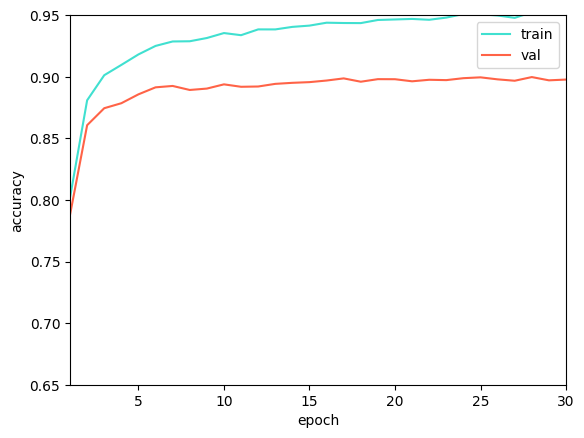

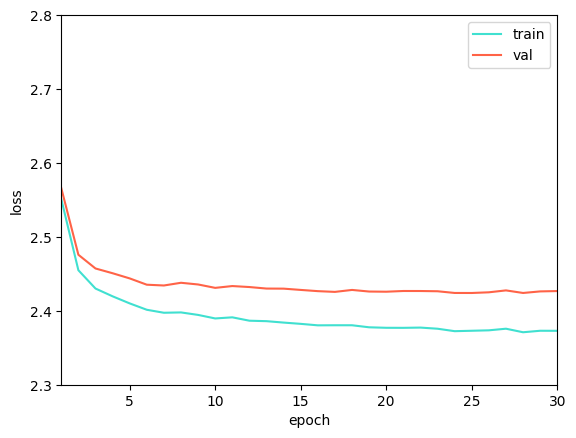

In [130]:
# 正解率を表示
x = range(1,31,1)
plt.xlim(1,30)
plt.ylim(0.65,0.95)
plt.plot(x, y_train_acc,label="train",color="turquoise")
plt.plot(x, y_val_acc,label="val",color="tomato")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# lossを表示
x = range(1,31,1)
plt.xlim(1,30)
plt.ylim(2.3,2.8)
plt.plot(x, y_train_loss,label="train",color="turquoise")
plt.plot(x, y_val_loss,label="val",color="tomato")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

#### 【正解率】 (ベース) → (Heの初期値) → (バッチ正規化) → (層を深くする)
- 10 epoch: 79.58% → 79.66% → 86.95% → 89.38%
- 20 epoch: 86.04% → 81.04% → 87.99% → 89.8%
- 30 epoch: 87.35% → 87% → 88.2% → 89.77%

### 【現状確認】
#### ベスト正解率 = 89.7%

### 【考察】
- 正解率が90%手前で停滞する。
- 学習率の最適化に余地は残されているが、1次元での解析では大幅な改善は難しい

### 【方策】・・・2次元データでの学習を行う
4. CNN / MaxPoolを用いたモデルを立てる
5. 層構造を最適化したモデルを作成する

---
### データローダーの作成
---

In [131]:
# バッチサイズ
batch_size = 16

# データセット
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(x_val_tensor, y_val_tensor)

# データローダー
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

---
### 【モデル作成】
### 　　4. CNN / MaxPoolを用いたモデルを立てる
### 　　(CNNブロック×2個)
---

In [136]:
# モデルの作成
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CNN Block1
        # OH = (28+2-3)/1+1 = 28 (16CH)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        # OH = 28/2 = 14 (16CH)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # CNN Block2
        # OH = (14+2-3)/1+1 = 14 (32CH)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        # OH = 14/2 = 7 (32CH)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(7*7*32, 1024)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 1024)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(1024, 26)
        
    def forward(self, x):
        # CNN Block1
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.pool1(out)
        # CNN Block2
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.pool2(out)
        # 1次元に展開
        out = out.view(out.size()[0],-1)
        # 7*7*32 → 1024
        out = self.relu3(self.fc1(out))
        # 1024 → 1024
        out = self.relu4(self.fc2(out))
        # 1024 → 26
        out = self.fc3(out)
        
        return out

# モデルのインスタンス化
net = Net().to(device)

# 最適化手法の選択
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

# 目的関数(cross_entropyは内部でsoftmaxが使用されている)
criterion = nn.CrossEntropyLoss()

In [137]:
# エポック数
max_epoch = 10

# シード固定
torch.manual_seed(0)

# 訓練データ結果
y_train_acc = []
y_train_loss = []

# 検証データ結果
y_val_acc = []
y_val_loss = []

for epoch in range(max_epoch):

    # 正解率計算用
    correct = 0
    total = 0
    
    # 訓練モード
    net.train()
    for images, labels in train_loader:
        
        # バッチサイズ分のサンプルを抽出
        x = Variable(images.view(len(images),1,28,28),requires_grad=True)
        t = Variable(labels)
        
        # GPU用に変換
        x = x.to(device)
        t = t.to(device)
        
        # パワメータの勾配を初期化
        optimizer.zero_grad()
        
        # 予測値の算出
        y = net(x)
        
        # ラベルの予測値と正解とのロス計算
        loss = criterion(y, t)
        
        # 各パラメータの勾配を計算
        loss.backward()
        
        # パラメータの更新
        optimizer.step()
        
        # 正解数/全数の算出        
        y = torch.max(y.data, 1)[1]
        total += len(t)
        correct += (y == t).sum()        
        
    # 訓練データのloss/acc記録
    y_train_loss.append(loss.data.detach().cpu().numpy())
    y_train_acc.append((correct/float(total)).to('cpu').detach().numpy())    
    
    # 正解率計算用
    correct = 0
    total = 0

    # 検証モード
    net.eval()
    for i, (images, labels) in enumerate(test_loader):
        # バッチサイズ分の検証データ
        x = images.view(len(images),1,28,28)
        
        # GPU用に変換
        x = x.to(device)
        t = labels.to(device)
        
        # 予測値の算出
        y = net(x)

        # ラベルの予測値と正解とのロス計算
        loss = criterion(y, t)        

        y = torch.max(y.data, 1)[1]

        # 正解数/全数の算出
        total += len(t)
        correct += (y == t).sum()
                            
    # ロス/正解率の保存
    y_val_loss.append(loss.data.detach().cpu().numpy())
    y_val_acc.append((correct/float(total)).to('cpu').detach().numpy())
    print('epoch: {}'.format(epoch+1))
    print('[train] Loss: {:.4g}  Accuracy: {:.4g} %'.format(y_train_loss[epoch], y_train_acc[epoch]*100))
    print('[valid] Loss: {:.4g}  Accuracy: {:.4g} %'.format(y_val_loss[epoch], y_val_acc[epoch]*100))

epoch: 1
[train] Loss: 0.1908  Accuracy: 85.2 %
[valid] Loss: 0.2233  Accuracy: 91.07 %
epoch: 2
[train] Loss: 0.1003  Accuracy: 92.54 %
[valid] Loss: 0.1838  Accuracy: 91.68 %
epoch: 3
[train] Loss: 0.006974  Accuracy: 94.22 %
[valid] Loss: 0.1911  Accuracy: 91.83 %
epoch: 4
[train] Loss: 0.01544  Accuracy: 95.19 %
[valid] Loss: 0.1807  Accuracy: 92.12 %
epoch: 5
[train] Loss: 7.193e-05  Accuracy: 95.72 %
[valid] Loss: 0.1614  Accuracy: 92.59 %
epoch: 6
[train] Loss: 1.309e-05  Accuracy: 96.19 %
[valid] Loss: 0.2015  Accuracy: 92.73 %
epoch: 7
[train] Loss: 1.411e-05  Accuracy: 96.5 %
[valid] Loss: 0.1818  Accuracy: 92.77 %
epoch: 8
[train] Loss: 0.0006372  Accuracy: 96.75 %
[valid] Loss: 0.1268  Accuracy: 92.39 %
epoch: 9
[train] Loss: 0.0004198  Accuracy: 96.87 %
[valid] Loss: 0.1346  Accuracy: 92.4 %
epoch: 10
[train] Loss: 5.243e-05  Accuracy: 97.11 %
[valid] Loss: 0.1591  Accuracy: 92.86 %


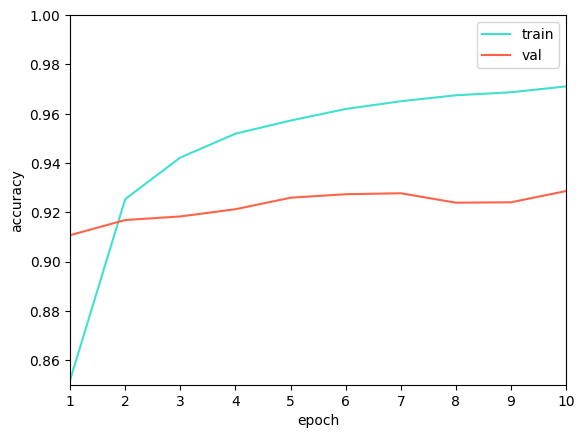

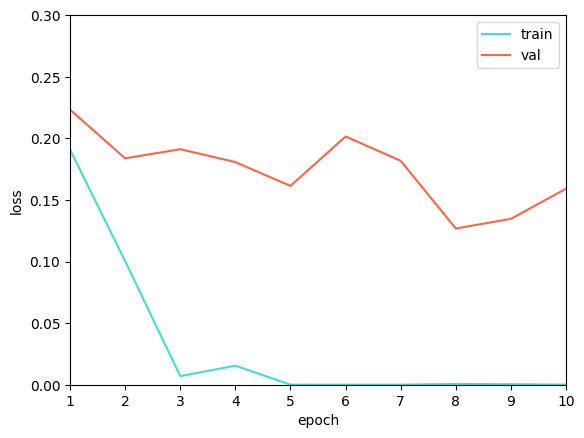

In [139]:
# 正解率を表示
x = range(1,11,1)
plt.xlim(1,10)
plt.ylim(0.85,1)
plt.plot(x, y_train_acc,label="train",color="turquoise")
plt.plot(x, y_val_acc,label="val",color="tomato")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# lossを表示
x = range(1,11,1)
plt.xlim(1,10)
plt.ylim(0,0.3)
plt.plot(x, y_train_loss,label="train",color="turquoise")
plt.plot(x, y_val_loss,label="val",color="tomato")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

#### 【正解率】 (全結合層のみ) → (CNN)
- 89.7% → 92.86%

---
### 【モデル作成】
### 　　5. 層構造を最適化したモデルを作成する
### 　　(CNNブロック×4)
---

In [140]:
# モデルの作成
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CNN Block1
        # OH = (28+2-3)/1+1 = 28 (32CH)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.BN1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        # OH = (28+2-3)/1+1 = 28 (32CH)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.BN2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU(inplace=True)
        # OH = 28/2 = 14 (32CH)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # OH = (14+2-3)/1+1 = 14 (64CH)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.BN3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU(inplace=True)
        # OH = (14+2-3)/1+1 = 14 (64CH)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.BN4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU(inplace=True)
        # OH = 14/2 = 7 (64CH)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Drop1 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(64*7*7,512)
        self.BN5 = nn.BatchNorm1d(512)
        self.relu5 = nn.ReLU(inplace=True)
        self.Drop2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512,512)
        self.BN6 = nn.BatchNorm1d(512)
        self.relu6 = nn.ReLU(inplace=True)
        self.Drop3 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(512,26)
        
    def forward(self, x):
        # CNN Block1
        out = self.conv1(x)
        out = self.BN1(out)
        out = self.relu1(out)
        # CNN Block2
        out = self.conv2(out)
        out = self.BN2(out)
        out = self.relu2(out)
        out = self.pool1(out)
        # CNN Block3
        out = self.conv3(out)
        out = self.BN3(out)
        out = self.relu3(out)
        # CNN Block4
        out = self.conv4(out)
        out = self.BN4(out)
        out = self.relu4(out)
        out = self.pool2(out)

        out = out.view(out.size()[0],-1)
        
        # 64*7*7 → 512
        out = self.Drop1(out)
        out = self.fc1(out)
        out = self.BN5(out)
        out = self.relu5(out)
        # 512 → 512
        out = self.Drop2(out)
        out = self.fc2(out)
        out = self.BN6(out)
        out = self.relu6(out)
        # 512 → 26
        out = self.Drop3(out)
        out = self.fc3(out)
        
        return out

# モデルのインスタンス化
net = Net().to(device)

# 最適化手法の選択
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

# 目的関数(cross_entropyは内部でsoftmaxが使用されている)
criterion = nn.CrossEntropyLoss()

In [141]:
# エポック数
max_epoch = 10

# シード固定
torch.manual_seed(0)

# 訓練データ結果
y_train_acc = []
y_train_loss = []

# 検証データ結果
y_val_acc = []
y_val_loss = []

for epoch in range(max_epoch):

    # 正解率計算用
    correct = 0
    total = 0
    
    # 訓練モード
    net.train()
    for images, labels in train_loader:
        
        # バッチサイズ分のサンプルを抽出
        x = Variable(images.view(len(images),1,28,28),requires_grad=True)
        t = Variable(labels)
        
        # GPU用に変換
        x = x.to(device)
        t = t.to(device)
        
        # パワメータの勾配を初期化
        optimizer.zero_grad()
        
        # 予測値の算出
        y = net(x)
        
        # ラベルの予測値と正解とのロス計算
        loss = criterion(y, t)
        
        # 各パラメータの勾配を計算
        loss.backward()
        
        # パラメータの更新
        optimizer.step()
        
        # 正解数/全数の算出        
        y = torch.max(y.data, 1)[1]
        total += len(t)
        correct += (y == t).sum()        
        
    # 訓練データのloss/acc記録
    y_train_loss.append(loss.data.detach().cpu().numpy())
    y_train_acc.append((correct/float(total)).to('cpu').detach().numpy())    
    
    # 正解率計算用
    correct = 0
    total = 0

    # 検証モード
    net.eval()
    for i, (images, labels) in enumerate(test_loader):
        # バッチサイズ分の検証データ
        x = images.view(len(images),1,28,28)
        
        # GPU用に変換
        x = x.to(device)
        t = labels.to(device)
        
        # 予測値の算出
        y = net(x)

        # ラベルの予測値と正解とのロス計算
        loss = criterion(y, t)        

        y = torch.max(y.data, 1)[1]

        # 正解数/全数の算出
        total += len(t)
        correct += (y == t).sum()
                            
    # ロス/正解率の保存
    y_val_loss.append(loss.data.detach().cpu().numpy())
    y_val_acc.append((correct/float(total)).to('cpu').detach().numpy())
    print('epoch: {}'.format(epoch+1))
    print('[train] Loss: {:.4g}  Accuracy: {:.4g} %'.format(y_train_loss[epoch], y_train_acc[epoch]*100))
    print('[valid] Loss: {:.4g}  Accuracy: {:.4g} %'.format(y_val_loss[epoch], y_val_acc[epoch]*100))

epoch: 1
[train] Loss: 0.1167  Accuracy: 79.38 %
[valid] Loss: 0.1012  Accuracy: 92.62 %
epoch: 2
[train] Loss: 0.1239  Accuracy: 87.27 %
[valid] Loss: 0.08815  Accuracy: 93.55 %
epoch: 3
[train] Loss: 0.1829  Accuracy: 89.07 %
[valid] Loss: 0.08564  Accuracy: 93.81 %
epoch: 4
[train] Loss: 0.1944  Accuracy: 90.17 %
[valid] Loss: 0.08926  Accuracy: 94.26 %
epoch: 5
[train] Loss: 0.05373  Accuracy: 90.95 %
[valid] Loss: 0.07907  Accuracy: 94.32 %
epoch: 6
[train] Loss: 0.05495  Accuracy: 91.38 %
[valid] Loss: 0.1077  Accuracy: 94.38 %
epoch: 7
[train] Loss: 0.1554  Accuracy: 91.89 %
[valid] Loss: 0.1161  Accuracy: 94.67 %
epoch: 8
[train] Loss: 0.01574  Accuracy: 92.16 %
[valid] Loss: 0.107  Accuracy: 94.75 %
epoch: 9
[train] Loss: 0.0202  Accuracy: 92.34 %
[valid] Loss: 0.09556  Accuracy: 94.61 %
epoch: 10
[train] Loss: 0.003653  Accuracy: 92.75 %
[valid] Loss: 0.1311  Accuracy: 94.81 %


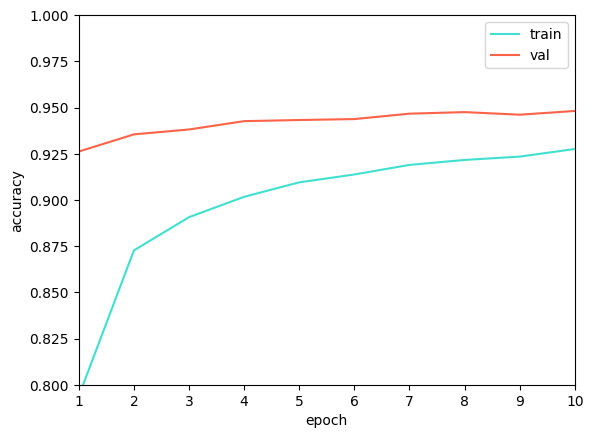

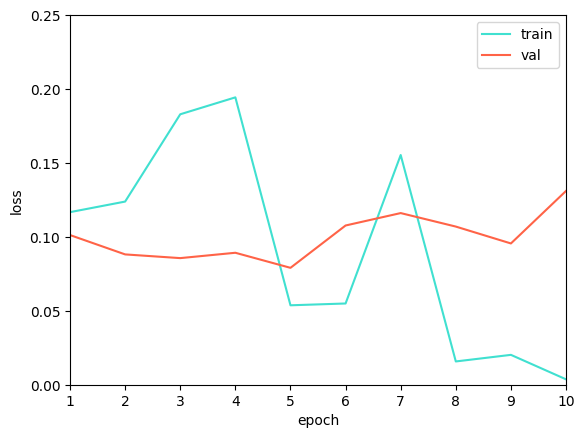

In [143]:
# 正解率を表示
x = range(1,11,1)
plt.xlim(1,10)
plt.ylim(0.8,1)
plt.plot(x, y_train_acc,label="train",color="turquoise")
plt.plot(x, y_val_acc,label="val",color="tomato")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# lossを表示
x = range(1,11,1)
plt.xlim(1,10)
plt.ylim(0,0.25)
plt.plot(x, y_train_loss,label="train",color="turquoise")
plt.plot(x, y_val_loss,label="val",color="tomato")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

#### 【正解率】 (全結合層のみ) → (CNN) → (CNN最適化)
- 89.7% → 92.86% → 94.81% (約95%)

#### 【結果】
- 全結合層のみの場合 = 89.7%
- CNN層を用いた場合 = 94.81%

#### 【所感】
- 最適な層構造、パラメータの選び方はまだ改善の余地がある
- (例えば、ミニバッチ数、学習率、CNNブロックの構造)

#### 【今後の展望】
- 画像認識の次ステップとして、次の機会には画像検出に取り組んでみたい

### 以上です。